## Imports and Dataframe Setup

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from scipy.stats import kurtosis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

### Loading specific dataset for model. This notebook reflects several datasets used for modeling that can easily be changed by adding and removing docstrings

In [2]:
import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM TIME_SERIES_REGRESSION_5"  #Name of table 

# Create a DataFrame from the SQL query
df_violent = pd.read_sql(query, engine)

#Try Model using violent crimes per capita instead of just total violent crime
"""
df_violent = df_violent.drop(columns=['Violent Crimes'])
df_violent = df_violent.rename(columns={'Violent Crimes per Capita': 'Violent Crimes'})
"""

#If using total violent crime and not crimes per capita
df_violent = df_violent.drop(columns=['Violent Crimes per Capita'])
df_violent = df_violent.drop(columns=['TOTAL POPULATION'])
df_violent = df_violent.drop(columns=['Units'])
#Drop Units per SqKm (weak correlation)
#df_violent = df_violent.drop(columns=['Units per SqKm'])

## Prepping for Machine Learing Model

In [8]:
# Converting the 'Month' column to datetime
df_violent['Month'] = pd.to_datetime(df_violent['Month'])

# Selecting numerical columns for standardization
numerical_columns = df_violent.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop(['Sector', 'Violent Crimes'])

# Applying standardization
scaler = StandardScaler()
df_violent[numerical_columns] = scaler.fit_transform(df_violent[numerical_columns])

df_violent.head()

,Sector,Month,Violent Crimes,SAFETY,S_EDUCATION_LOW,S_EDUCATION_MEDIUM,S_EDUCATION_HIGH,S_INCOME_LOW,S_INCOME_MEDIUM,S_INCOME_HIGH,...,Population Density (people/sqkm),Units per SqKm,Units per Capita,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,110,2017-11-01,66,1.279775,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310463,-0.691521,-0.648884,-0.976906,-0.734127,-1.190284,-1.433061,-2.467678,2.025042,-1.428339
1,110,2017-12-01,52,0.958365,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310463,-0.691521,-0.648884,-0.976906,-0.734127,-1.190284,-1.433061,-2.467678,2.025042,-1.428339
2,110,2018-01-01,74,1.797046,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310463,-0.691521,-0.648884,-0.976906,-0.734127,-1.190284,-1.433061,-2.467678,2.025042,-1.428339
3,110,2018-02-01,73,2.212620,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310463,-0.691521,-0.648884,-0.976906,-0.734127,-1.190284,-1.433061,-2.467678,2.025042,-1.428339
4,110,2018-03-01,84,1.991650,0.645498,2.230172,1.297663,0.891993,2.184311,1.098875,...,0.310463,-0.691521,-0.648884,-0.976906,-0.734127,-1.190284,-1.433061,-2.467678,2.025042,-1.428339


### Creating a new dataframe. Removing months and adding lag features for additional time-series analysis for a regression

In [10]:
#Dropping dates that don't have demographic specific Trust and Safety scores  
df_violent.set_index('Month', inplace=True)

# Filtering the data to include only dates from March 2018 onwards
df_violent_filtered = df_violent[df_violent.index >= '2018-03-01']

#Create lag features 

# List of columns to exclude. Static variables that do not have time component 
exclude_columns = ['Violent Crimes', 'Sector', 'Population Density (people/sqkm)', 'Units per Capita', 'Units per SqKm',
                  'PERCENT_OF_HOUSING_CROWDED', 'PERCENT_HOUSEHOLDS_BELOW_POVERTY',
                   'PERCENT_AGED_16_UNEMPLOYED','PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA',
               'PERCENT_AGED_UNDER_18_OR_OVER_64', 'PER_CAPITA_INCOME','HARDSHIP_INDEX', 'PERCENT_OF_HOUSING_CROWDED']  


# Creating 1-month lagged features for numerical columns 
numerical_columns = df_violent_filtered.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

# Creating separate dataframe from copy (to remove warning for using a slice of a copy)
df_violent_filtered_copy = df_violent_filtered.copy()

for column in numerical_columns:
    df_violent_filtered_copy[f'{column}_lag1'] = df_violent_filtered_copy[column].shift(1)

# Dropping the initial row with NaN values due to lagging
df_violent_filtered = df_violent_filtered_copy.dropna()

df_violent_filtered.head()



,Sector,Violent Crimes,SAFETY,S_EDUCATION_LOW,S_EDUCATION_MEDIUM,S_EDUCATION_HIGH,S_INCOME_LOW,S_INCOME_MEDIUM,S_INCOME_HIGH,TRUST,...,S_INCOME_LOW_lag1,S_INCOME_MEDIUM_lag1,S_INCOME_HIGH_lag1,TRUST_lag1,T_EDUCATION_LOW_lag1,T_EDUCATION_MEDIUM_lag1,T_EDUCATION_HIGH_lag1,T_INCOME_LOW_lag1,T_INCOME_MEDIUM_lag1,T_INCOME_HIGH_lag1
Month,,,,,,,,,,,,,,,,,,,,,
2018-04-01,110,64,1.655173,1.144687,1.678584,1.159504,0.494996,2.127500,0.935931,0.897079,...,0.891993,2.184311,1.098875,1.167625,0.052758,1.128835,0.840233,-0.027277,1.368428,0.887940
2018-05-01,110,79,2.105901,1.419731,2.693111,0.813076,0.651208,2.851046,1.368130,0.511497,...,0.494996,2.127500,0.935931,0.897079,-0.171098,0.996959,0.642263,-1.026521,1.473232,0.771547
2018-06-01,110,67,2.120968,1.625279,2.317725,1.060524,1.116859,2.038530,1.656263,0.644640,...,0.651208,2.851046,1.368130,0.511497,-0.283915,0.714106,0.264570,-0.575989,1.089254,-0.010649
2018-07-01,110,91,1.763147,0.857898,1.726739,1.094549,0.890003,1.409313,1.460531,1.015310,...,1.116859,2.038530,1.656263,0.644640,0.079407,0.916923,-0.273689,0.495743,-0.209043,0.548626
2018-08-01,110,96,1.927619,1.209288,1.649035,1.675022,0.981541,1.282827,1.442647,1.385979,...,0.890003,1.409313,1.460531,1.015310,0.963282,1.006053,0.180638,1.180258,0.162286,0.900763


### Creating training and testing data splits

In [12]:
X = df_violent_filtered.drop(['Violent Crimes', 'Sector'], axis=1)
y = df_violent_filtered['Violent Crimes']

split_idx = int(len(df_violent_filtered) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [13]:
#Code to see what happens when allowing sector (ie. location) be a feature

"""
#Splitting into training and testing data

# Separating features and target variable
X = df_violent_filtered.drop(['Violent Crimes'], axis=1)
y = df_violent_filtered['Violent Crimes']

# Splitting the dataset into training and testing sets 
split_idx = int(len(df_violent_filtered) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
"""


"\n#Splitting into training and testing data\n\n# Separating features and target variable\nX = df_violent_filtered.drop(['Violent Crimes'], axis=1)\ny = df_violent_filtered['Violent Crimes']\n\n# Splitting the dataset into training and testing sets \nsplit_idx = int(len(df_violent_filtered) * 0.8)\nX_train, X_test = X[:split_idx], X[split_idx:]\ny_train, y_test = y[:split_idx], y[split_idx:]\n"

## Creating Regression Models

In [14]:
# Initializing the Linear Regression model
lr_model = LinearRegression()

# Training the model on the training set
lr_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Displaying the evaluation metrics
mae, mse, rmse, r2

(20.302294745582582,
 670.7215974739377,
 25.898293331297676,
 0.44939059786249425)

### Looking at other models

In [15]:
#Iterating through dictionary of different models, creating a model from data splits, and generating scores for each

# Initializing the models
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()
svr_model = SVR()
ridge_model = Ridge()
lasso_model = Lasso()
elastic_net_model = ElasticNet()

# Dictionary to store models and their predictions
models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Support Vector Regression": svr_model,
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_model,
    "Elastic Net": elastic_net_model
}

# Dictionary to store evaluation metrics
model_metrics = {}

# Training each model and evaluating
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    model_metrics[model_name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

# Displaying the evaluation metrics for each model
model_metrics

{'Random Forest': {'MAE': 12.183416216216216,
  'MSE': 250.3530570810811,
  'RMSE': 15.822549007068396,
  'R2': 0.7944799338475644},
 'Gradient Boosting': {'MAE': 12.871462278031968,
  'MSE': 272.1793980121933,
  'RMSE': 16.497860407101076,
  'R2': 0.7765622336032451},
 'Support Vector Regression': {'MAE': 19.19844661585312,
  'MSE': 614.1495809936104,
  'RMSE': 24.78204150173287,
  'R2': 0.4958317506287976},
 'Ridge Regression': {'MAE': 20.30094484060002,
  'MSE': 670.7318396967612,
  'RMSE': 25.898491069882066,
  'R2': 0.4493821898073389},
 'Lasso Regression': {'MAE': 20.926396367689065,
  'MSE': 694.8177515756638,
  'RMSE': 26.359395887911845,
  'R2': 0.42960956046376897},
 'Elastic Net': {'MAE': 21.500175988391454,
  'MSE': 723.425998130107,
  'RMSE': 26.89657967344746,
  'R2': 0.4061244519017826}}

### Random Forest the best performing model. Let's proceed with this model

In [16]:
# Initializing the Random Forest regressor
rf_model = RandomForestRegressor()

# Experiment with random_states
#rf_model = RandomForestRegressor(random_state=42)

# Training the model on the training set
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse= mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Displaying the evaluation metrics
mae, mse, rmse, r2

(12.03852972972973, 244.7231535135135, 15.643629806202698, 0.7991016395584062)

## Feature Analysis, Hyperparameter Tuning, etc. :


### Feature Analysis/Importance

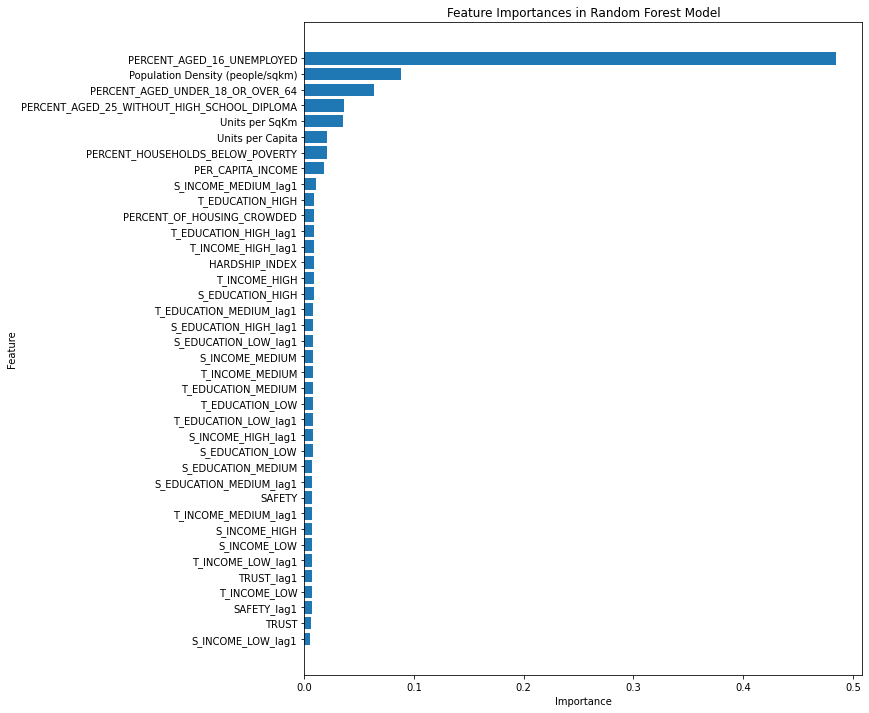

In [17]:
#Analyzing most important features that the model is using for prediction 

# Extract feature importances
importances = rf_model.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis() 
plt.show()

### Hyperparemeter Tuning

In [18]:
#Takes awhile to run. Add and remove docstrings as needed. Run when using new model
"""
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameters grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
"""

'\n# Define the model\nrf = RandomForestRegressor(random_state=42)\n\n# Define the parameters grid\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],  # Number of trees in the forest\n    \'max_depth\': [10, 20, 30],        # Maximum depth of the tree\n    \'min_samples_split\': [2, 5, 10]   # Minimum number of samples required to split an internal node\n}\n\n# Initialize Grid Search\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, \n                           cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\n\n# Fit the grid search to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameters\nprint("Best parameters found: ", grid_search.best_params_)\n'

### Results of above (save time having to re-run when running all cells):
##### Fitting 3 folds for each of 27 candidates, totalling 81 fits
##### Best parameters found:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}

### Creating model with parameters above

In [19]:

# Initialize the Random Forest regressor with the best parameters
rf_model_best = RandomForestRegressor(max_depth=20, 
                                      min_samples_split=2, 
                                      n_estimators=300,
                                      random_state=42)

# Train the model on the training set
rf_model_best.fit(X_train, y_train)

# Making predictions on the test set
y_pred_best = rf_model_best.predict(X_test)

# Evaluating the model with the best parameters
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

# Displaying the evaluation metrics with the best parameters
print('MAE:', mae_best)
print('MSE:', mse_best)
print('RMSE:', rmse_best)
print('R2:', r2_best)

MAE: 11.997059753465715
MSE: 243.3411783045777
RMSE: 15.59939672886672
R2: 0.800236131941575


## Visuals

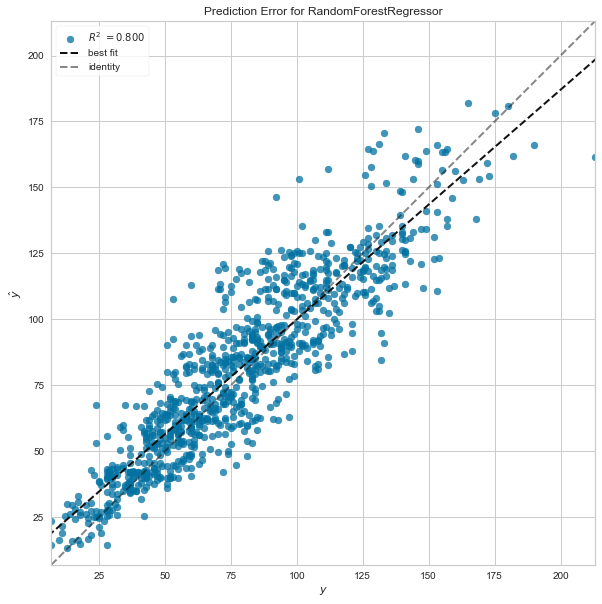

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [20]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
model = RandomForestRegressor(max_depth=20, 
                                      min_samples_split=2, 
                                      n_estimators=300,
                                      random_state=42)

visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


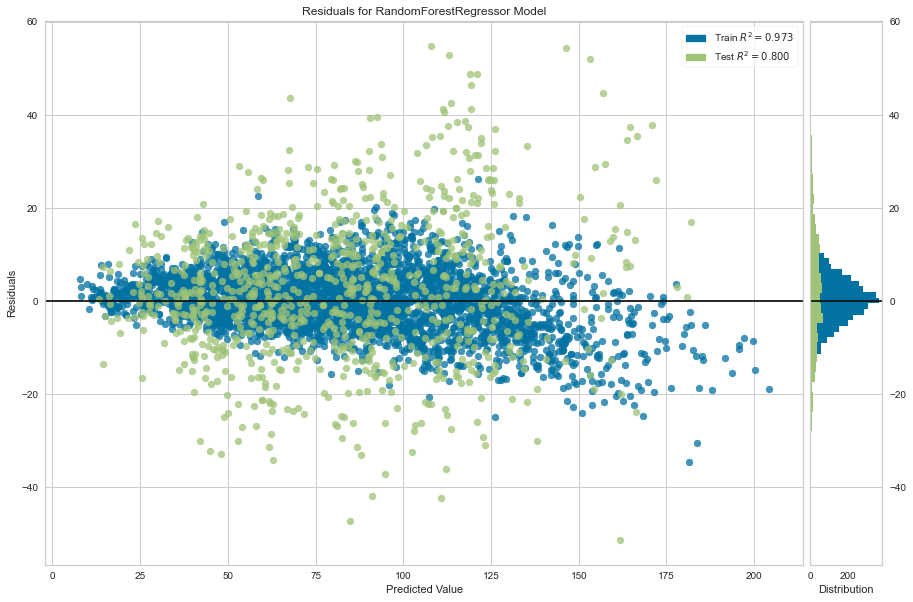

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [21]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


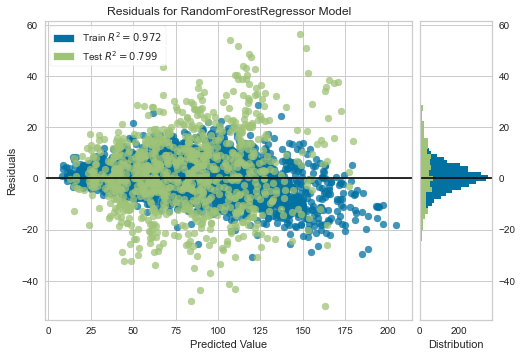

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


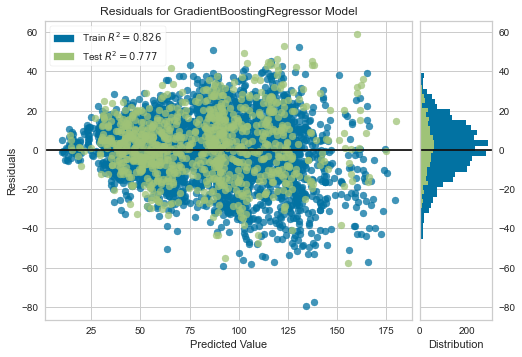

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


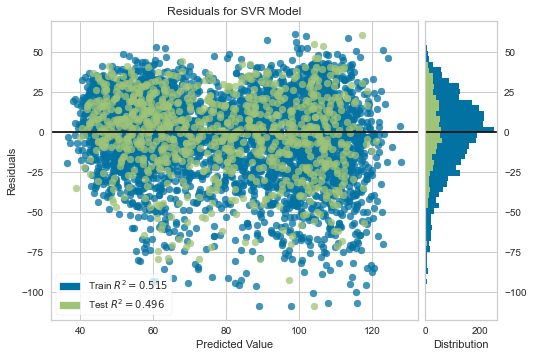

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


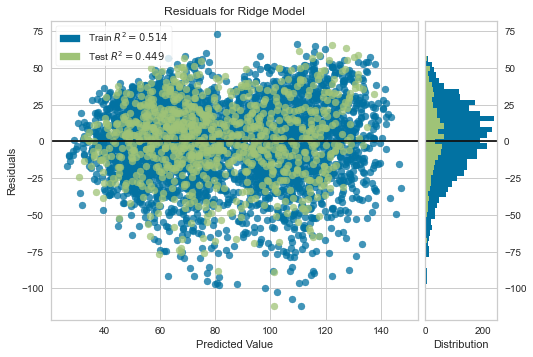

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


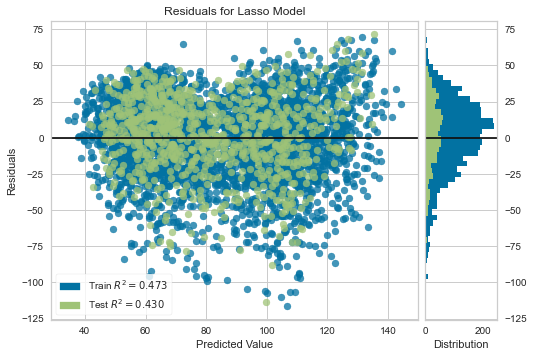

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


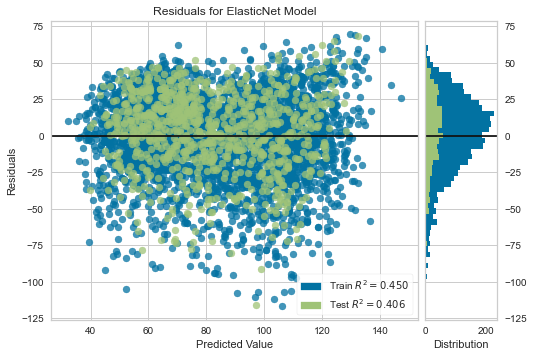

In [22]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression

regressors = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Support Vector Regression": svr_model,
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_model,
    "Elastic Net": elastic_net_model
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

Computing partial dependence plots...
done in 4.006s


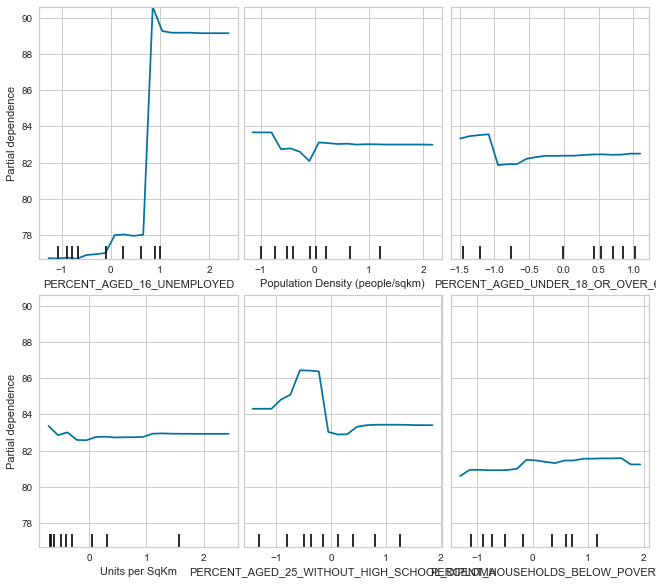

In [62]:
#Not sure how to interpret these yet 

from sklearn.inspection import PartialDependenceDisplay
from time import time

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ['PERCENT_AGED_16_UNEMPLOYED', 'Population Density (people/sqkm)',
       'PERCENT_AGED_UNDER_18_OR_OVER_64','Units per SqKm',
       'PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA',
       'PERCENT_HOUSEHOLDS_BELOW_POVERTY'],
    # type of partial dependence plot
    "kind": "average"
}
tic = time()

_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")

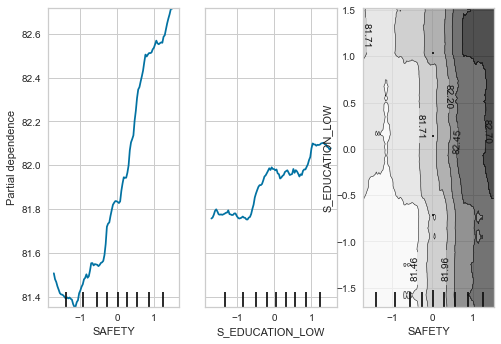

In [24]:
from sklearn.inspection import PartialDependenceDisplay

RandomForest = model.fit(X, y)
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(RandomForest, X, features)

In [32]:
lr_model.fit(X, y)

print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", lr_model.coef_[i].round(5))

Model coefficients:

SAFETY = 1.23266
S_EDUCATION_LOW = 0.79433
S_EDUCATION_MEDIUM = 0.70954
S_EDUCATION_HIGH = 0.63422
S_INCOME_LOW = -2.51257
S_INCOME_MEDIUM = -2.08677
S_INCOME_HIGH = -2.19403
TRUST = 2.65038
T_EDUCATION_LOW = -3.01696
T_EDUCATION_MEDIUM = -3.07441
T_EDUCATION_HIGH = -2.25843
T_INCOME_LOW = -0.81727
T_INCOME_MEDIUM = -0.3098
T_INCOME_HIGH = 1.16032
Population Density (people/sqkm) = -0.64049
Units per SqKm = -8.13379
Units per Capita = 8.84898
PERCENT_OF_HOUSING_CROWDED = 1.97136
PERCENT_HOUSEHOLDS_BELOW_POVERTY = -9.09416
PERCENT_AGED_16_UNEMPLOYED = -1.84012
PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA = -20.49564
PERCENT_AGED_UNDER_18_OR_OVER_64 = -2.78847
PER_CAPITA_INCOME = 11.08611
HARDSHIP_INDEX = 49.43103
SAFETY_lag1 = -2.22436
S_EDUCATION_LOW_lag1 = 2.19622
S_EDUCATION_MEDIUM_lag1 = 1.2732
S_EDUCATION_HIGH_lag1 = -1.03975
S_INCOME_LOW_lag1 = -1.27051
S_INCOME_MEDIUM_lag1 = 0.70697
S_INCOME_HIGH_lag1 = 0.5034
TRUST_lag1 = -1.755
T_EDUCATION_LOW_lag1 = -3.9983

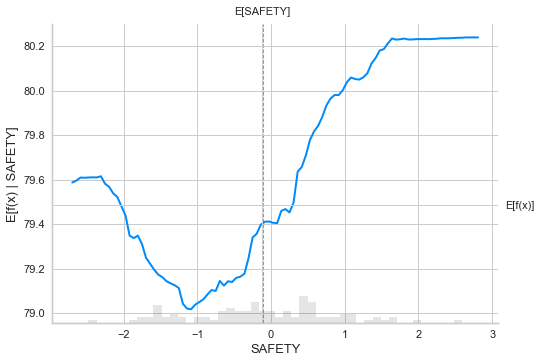

In [34]:
import shap

X100 = shap.utils.sample(X, 100) 

shap.partial_dependence_plot(
    "SAFETY",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

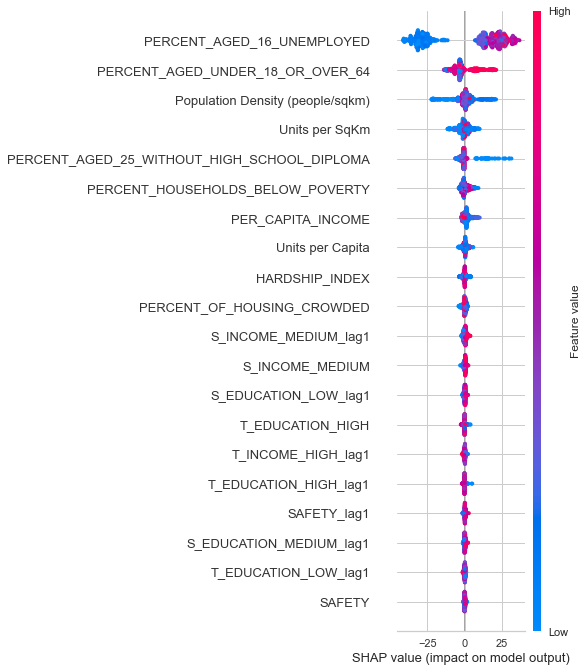

In [41]:
import shap

model.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = model.predict(X_test)

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Mean Squared Error: 243.3411783045777


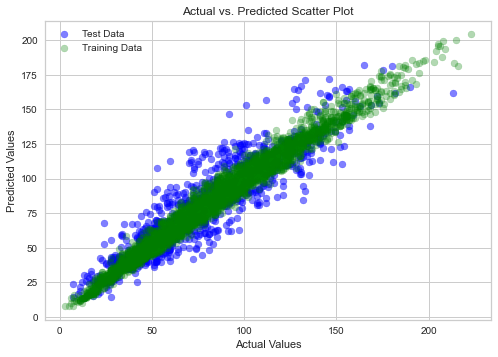

In [47]:
from sklearn.metrics import mean_squared_error

# Train the model
model = RandomForestRegressor(max_depth=20, 
                                      min_samples_split=2, 
                                      n_estimators=300,
                                      random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) for evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Create Actual vs. Predicted Scatter Plot
plt.scatter(y_test, y_pred, alpha=0.5, label='Test Data', color='blue')
plt.scatter(y_train, model.predict(X_train), alpha=0.3, label='Training Data', color='green')
plt.title('Actual vs. Predicted Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [63]:
'''from sklearn.model_selection import KFold
from yellowbrick.model_selection import rfecv

cv = KFold(n_splits=5, shuffle=True, random_state=42)
visualizer = rfecv(RandomForestRegressor(), X=X, y=y, cv=cv, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure
'''

"from sklearn.model_selection import KFold\nfrom yellowbrick.model_selection import rfecv\n\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\nvisualizer = rfecv(RandomForestRegressor(), X=X, y=y, cv=cv, scoring='r2')\n\nvisualizer.fit(X, y)        # Fit the data to the visualizer\nvisualizer.show()           # Finalize and render the figure\n"

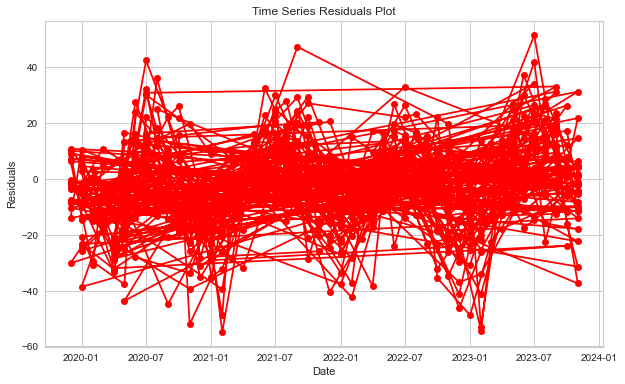

In [53]:
model = RandomForestRegressor(max_depth=20, 
                                      min_samples_split=2, 
                                      n_estimators=300,
                                      random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Create a Time Series Residuals Plot
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, residuals, marker='o', linestyle='-', color='red')
plt.title('Time Series Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

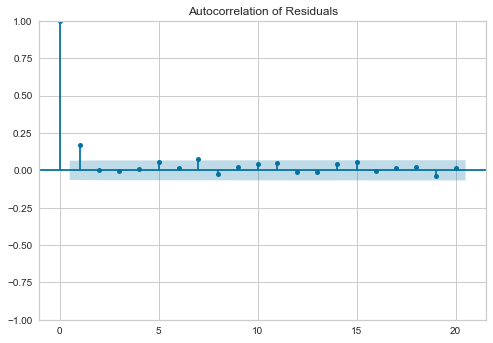

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()

Optimal number of features: 33


The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


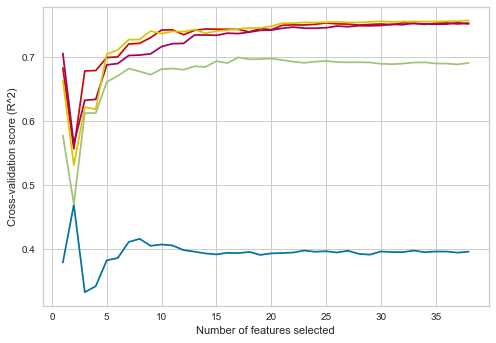

Mean Squared Error on Test Set: 245.23543025534374


In [56]:
from sklearn.feature_selection import RFECV

# Create a RandomForestRegressor as the base model
model = RandomForestRegressor(max_depth=20, 
                                      min_samples_split=2, 
                                      n_estimators=300,
                                      random_state=42)

# Initialize RFECV
rfecv = RFECV(estimator=model, step=1, cv=5)  # You can adjust the number of cross-validation folds (cv) and step size as needed

# Fit RFECV on training data
rfecv.fit(X_train, y_train)

# Visualize the feature ranking
print("Optimal number of features: {}".format(rfecv.n_features_))

# Plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (R^2)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Use the selected features for modeling
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train your model on the selected features
model.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test_selected)

# Calculate evaluation metrics (e.g., Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

Optimal number of features: 33
Mean Squared Error on Test Set: 245.23543025534374


In [59]:
X_train_selected.columns

Index(['S_EDUCATION_LOW', 'S_EDUCATION_MEDIUM', 'S_EDUCATION_HIGH',
       'S_INCOME_LOW', 'S_INCOME_MEDIUM', 'S_INCOME_HIGH', 'T_EDUCATION_LOW',
       'T_EDUCATION_MEDIUM', 'T_EDUCATION_HIGH', 'T_INCOME_LOW',
       'T_INCOME_MEDIUM', 'T_INCOME_HIGH', 'Population Density (people/sqkm)',
       'Units per SqKm', 'Units per Capita', 'PERCENT_OF_HOUSING_CROWDED',
       'PERCENT_HOUSEHOLDS_BELOW_POVERTY', 'PERCENT_AGED_16_UNEMPLOYED',
       'PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA',
       'PERCENT_AGED_UNDER_18_OR_OVER_64', 'PER_CAPITA_INCOME',
       'HARDSHIP_INDEX', 'SAFETY_lag1', 'S_EDUCATION_LOW_lag1',
       'S_EDUCATION_HIGH_lag1', 'S_INCOME_MEDIUM_lag1', 'S_INCOME_HIGH_lag1',
       'T_EDUCATION_LOW_lag1', 'T_EDUCATION_MEDIUM_lag1',
       'T_EDUCATION_HIGH_lag1', 'T_INCOME_LOW_lag1', 'T_INCOME_MEDIUM_lag1',
       'T_INCOME_HIGH_lag1'],
      dtype='object')

In [60]:
X_train.columns

Index(['SAFETY', 'S_EDUCATION_LOW', 'S_EDUCATION_MEDIUM', 'S_EDUCATION_HIGH',
       'S_INCOME_LOW', 'S_INCOME_MEDIUM', 'S_INCOME_HIGH', 'TRUST',
       'T_EDUCATION_LOW', 'T_EDUCATION_MEDIUM', 'T_EDUCATION_HIGH',
       'T_INCOME_LOW', 'T_INCOME_MEDIUM', 'T_INCOME_HIGH',
       'Population Density (people/sqkm)', 'Units per SqKm',
       'Units per Capita', 'PERCENT_OF_HOUSING_CROWDED',
       'PERCENT_HOUSEHOLDS_BELOW_POVERTY', 'PERCENT_AGED_16_UNEMPLOYED',
       'PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA',
       'PERCENT_AGED_UNDER_18_OR_OVER_64', 'PER_CAPITA_INCOME',
       'HARDSHIP_INDEX', 'SAFETY_lag1', 'S_EDUCATION_LOW_lag1',
       'S_EDUCATION_MEDIUM_lag1', 'S_EDUCATION_HIGH_lag1', 'S_INCOME_LOW_lag1',
       'S_INCOME_MEDIUM_lag1', 'S_INCOME_HIGH_lag1', 'TRUST_lag1',
       'T_EDUCATION_LOW_lag1', 'T_EDUCATION_MEDIUM_lag1',
       'T_EDUCATION_HIGH_lag1', 'T_INCOME_LOW_lag1', 'T_INCOME_MEDIUM_lag1',
       'T_INCOME_HIGH_lag1'],
      dtype='object')